# Notebook to generate model likelihood plot

This notebook requires the modeling results data, saved in
`../../cache/phys_modeling_logs/main`. This can be downloaded from the OSF
repo or can be generated by training the models yourself.

In [1]:
"""Imports."""

import json
import torch
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy import stats as scipy_stats

# Matplotlib settings
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['figure.dpi'] = 300

In [ ]:
"""Load results."""

np.random.seed(42)  # For reproducibility
torch.manual_seed(42)  # For reproducibility

BASE_RESULTS_DIR = Path("../../../cache/modeling/main")
SEEDS = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
MODEL_TO_NAME = {
    "triangle_slot": "Slot",
    "triangle_slot_partition": "Slot",
    "triangle_switching": "Switching",
    "triangle_gain": "Gain",
}
MODEL_ORDER = ["Slot", "Switching", "Gain"]
MODEL_DIRS = [
    "triangle_slot_partition",
    # "triangle_slot",
    "triangle_switching",
    "triangle_gain",
]
SUBJECT_SESSIONS = [
    ("Elgar", "2022-08-19"),
    ("Elgar", "2022-08-20"),
    ("Elgar", "2022-08-21"),
    ("Elgar", "2022-08-22"),
    ("Elgar", "2022-08-23"),
    ("Elgar", "2022-08-24"),
    ("Elgar", "2022-08-25"),
    ("Elgar", "2022-08-26"),
    ("Elgar", "2022-08-31"),
    ("Elgar", "2022-09-01"),
    ("Elgar", "2022-09-02"),
    ("Elgar", "2022-09-03"),
    ("Elgar", "2022-09-04"),
    ("Elgar", "2022-09-05"),
    ("Perle", "2022-05-26"),
    ("Perle", "2022-05-27"),
    ("Perle", "2022-05-28"),
    ("Perle", "2022-05-29"),
    ("Perle", "2022-05-30"),
    ("Perle", "2022-05-31"),
    ("Perle", "2022-06-01"),
    ("Perle", "2022-06-03"),
    ("Perle", "2022-06-04"),
    ("Perle", "2022-06-05"),
]

# Bootstrap function
def _compute_bootstrap_probs(ll_per_model, trials_per_bootstrap=100, n_bootstrap=1000):
    """Compute bootstrap probabilities."""
    # Get log-likelihoods
    models = list(ll_per_model.keys())
    ll_per_model_array = np.array([ll_per_model[k] for k in models])
    
    # Compute bootstrap probabilities
    probs_per_bootstrap = []
    for _ in range(n_bootstrap):
        trials = np.random.choice(
            ll_per_model_array.shape[1],
            size=trials_per_bootstrap,
            replace=True,
        )
        ll_bootstrap = np.sum(ll_per_model_array[:, trials], axis=1)
        ll_bootstrap = ll_bootstrap - ll_bootstrap.min()
        probs = np.exp(ll_bootstrap) / np.sum(np.exp(ll_bootstrap))
        probs_per_bootstrap.append(probs)
    
    # Return mean over bootstraps
    probs_per_bootstrap = {
        k: [x[i] for x in probs_per_bootstrap]
        for i, k in enumerate(models)
    }
    return probs_per_bootstrap

# Get data
data_df = {
    "subject": [],
    "session": [],
    "num_neurons": [],
    "seed": [],
    "model": [],
    "prob": [],
}
for subject, session in SUBJECT_SESSIONS:
    print(subject, session)
    for seed in SEEDS:
        # Get data per model
        test_ll_stats_per_model = {}
        num_neurons_per_model = {}
        for model_dir in MODEL_DIRS:
            log_dir = BASE_RESULTS_DIR / model_dir / subject / session / str(seed)
            if not log_dir.exists():
                raise ValueError(f"Log directory {log_dir} does not exist.")
            test_ll_stats = json.load(open(log_dir / "stop_step" / "eval_stats.json"))
            test_ll_stats_per_model[model_dir] = test_ll_stats
            num_neurons = json.load(open(log_dir / "test_metrics.json"))[0]["num_neurons"]
            num_neurons_per_model[model_dir] = num_neurons
        
        # Validate have same trials per unit for each model
        trials_per_unit_str = {
            k: str(v["trials_per_unit"])
            for k, v in test_ll_stats_per_model.items()
        }
        trials_per_unit = set(trials_per_unit_str.values())
        if len(trials_per_unit) != 1:
            raise ValueError(f"Trials per unit mismatch: {trials_per_unit_str}")
        
        # Compute probabilities per model
        ll_per_model = {}
        for model, test_ll_stats in test_ll_stats_per_model.items():
            flat_ll = []
            for x in test_ll_stats["ll_per_unit"]:
                flat_ll.extend(x)
            ll_per_model[model] = flat_ll
        bootstrap_probs = _compute_bootstrap_probs(ll_per_model)
        for model, probs in bootstrap_probs.items():
            n_probs = len(probs)
            data_df["subject"].append(subject)
            data_df["session"].append(session)
            data_df["num_neurons"].append(num_neurons_per_model[model])
            data_df["seed"].append(seed)
            data_df["model"].append(MODEL_TO_NAME[model])
            data_df["prob"].append(np.mean(probs))

# Convert to dataframe
data_df = pd.DataFrame(data_df)

Elgar 2022-08-19
Elgar 2022-08-20
Elgar 2022-08-21
Elgar 2022-08-22
Elgar 2022-08-23
Elgar 2022-08-24
Elgar 2022-08-25
Elgar 2022-08-26
Elgar 2022-08-31
Elgar 2022-09-01
Elgar 2022-09-02
Elgar 2022-09-03
Elgar 2022-09-04
Elgar 2022-09-05
Perle 2022-05-26
Perle 2022-05-27
Perle 2022-05-28
Perle 2022-05-29
Perle 2022-05-30
Perle 2022-05-31
Perle 2022-06-01
Perle 2022-06-03
Perle 2022-06-04
Perle 2022-06-05


In [4]:
for session in data_df.session.unique():
    df_session = data_df[data_df.session == session]
    subject = df_session.subject.iloc[0]
    num_neurons = df_session.num_neurons.iloc[0]
    print(f"Session: {session}, Subject: {subject}, Num Neurons: {num_neurons}")

Session: 2022-08-19, Subject: Elgar, Num Neurons: 102
Session: 2022-08-20, Subject: Elgar, Num Neurons: 125
Session: 2022-08-21, Subject: Elgar, Num Neurons: 37
Session: 2022-08-22, Subject: Elgar, Num Neurons: 96
Session: 2022-08-23, Subject: Elgar, Num Neurons: 49
Session: 2022-08-24, Subject: Elgar, Num Neurons: 123
Session: 2022-08-25, Subject: Elgar, Num Neurons: 29
Session: 2022-08-26, Subject: Elgar, Num Neurons: 39
Session: 2022-08-31, Subject: Elgar, Num Neurons: 95
Session: 2022-09-01, Subject: Elgar, Num Neurons: 62
Session: 2022-09-02, Subject: Elgar, Num Neurons: 30
Session: 2022-09-03, Subject: Elgar, Num Neurons: 69
Session: 2022-09-04, Subject: Elgar, Num Neurons: 95
Session: 2022-09-05, Subject: Elgar, Num Neurons: 56
Session: 2022-05-26, Subject: Perle, Num Neurons: 63
Session: 2022-05-27, Subject: Perle, Num Neurons: 70
Session: 2022-05-28, Subject: Perle, Num Neurons: 69
Session: 2022-05-29, Subject: Perle, Num Neurons: 58
Session: 2022-05-30, Subject: Perle, Num Ne

In [5]:
"""Print statistics."""

# For each subject, print mean probability per model and number of sessions
# where gain model is best
total_gain_best = []
total_gain_best_many_units = []
for subject in data_df["subject"].unique():
    print(f"Subject: {subject}")
    subject_df = data_df[data_df["subject"] == subject]
    
    # Mean probabilities per model
    mean_probs = subject_df.groupby("model")["prob"].mean()
    print("Mean probabilities per model:")
    print(mean_probs)
    
    # Number of sessions where gain model is best
    gain_best = []
    gain_best_many_units = []
    for session in subject_df["session"].unique():
        session_df = subject_df[subject_df["session"] == session]
        # Take mean probability per model
        session_probs = session_df.groupby("model")["prob"].mean()
        # Check if Gain model is best
        gain_best.append(session_probs.idxmax() == "Gain")
        # If session has more than 100 neurons, check if Gain model is best
        if session_df["num_neurons"].max() > 100:
            gain_best_many_units.append(session_probs.idxmax() == "Gain")
    gain_best_count = sum(gain_best)
    gain_best_percent = gain_best_count / len(gain_best) * 100
    gain_best_many_units_count = sum(gain_best_many_units)
    gain_best_many_units_percent = (
        gain_best_many_units_count / len(gain_best_many_units) * 100
    )
    print(f"# sessions where Gain is best: {gain_best_count} / {len(gain_best)}")
    print(f"% sessions where Gain is best: {gain_best_percent:.2f}%")
    print(f"# sessions where Gain is best (over 100 units): {gain_best_many_units_count} / {len(gain_best_many_units)}")
    print(f"% sessions where Gain is best (over 100 units): {gain_best_many_units_percent:.2f}%\n")
    
    # Extend total counts
    total_gain_best.extend(gain_best)
    total_gain_best_many_units.extend(gain_best_many_units)

# Print total counts
total_gain_best_count = sum(total_gain_best)
total_gain_best_percent = total_gain_best_count / len(total_gain_best) * 100
total_gain_best_many_units_count = sum(total_gain_best_many_units)
total_gain_best_many_units_percent = (
    total_gain_best_many_units_count / len(total_gain_best_many_units) * 100
)
print(f"Total # sessions where Gain is best: {total_gain_best_count} / {len(total_gain_best)}")
print(f"Total % sessions where Gain is best: {total_gain_best_percent:.2f}%")
print(f"Total # sessions where Gain is best (over 100 units): {total_gain_best_many_units_count} / {len(total_gain_best_many_units)}")
print(f"Total % sessions where Gain is best (over 100 units): {total_gain_best_many_units_percent:.2f}%")


Subject: Elgar
Mean probabilities per model:
model
Gain         0.434381
Slot         0.289073
Switching    0.276546
Name: prob, dtype: float64
# sessions where Gain is best: 12 / 14
% sessions where Gain is best: 85.71%
# sessions where Gain is best (over 100 units): 3 / 3
% sessions where Gain is best (over 100 units): 100.00%

Subject: Perle
Mean probabilities per model:
model
Gain         0.541511
Slot         0.260649
Switching    0.197839
Name: prob, dtype: float64
# sessions where Gain is best: 10 / 10
% sessions where Gain is best: 100.00%
# sessions where Gain is best (over 100 units): 5 / 5
% sessions where Gain is best (over 100 units): 100.00%

Total # sessions where Gain is best: 22 / 24
Total % sessions where Gain is best: 91.67%
Total # sessions where Gain is best (over 100 units): 8 / 8
Total % sessions where Gain is best (over 100 units): 100.00%


/var/folders/_h/nj1cpgkx7yl40q0b31fq3swr0000gn/T/ipykernel_8716/3670370846.py:46: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.06539923532130056' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  mean_per_session_df.loc[j, "model"] += _add_x_jitter(
/var/folders/_h/nj1cpgkx7yl40q0b31fq3swr0000gn/T/ipykernel_8716/3670370846.py:91: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(
/var/folders/_h/nj1cpgkx7yl40q0b31fq3swr0000gn/T/ipykernel_8716/3670370846.py:46: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.07016812268734503' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  mean_per_session_df.loc[j, "model"] += _add_x_jitter(
/var/folders/_h/

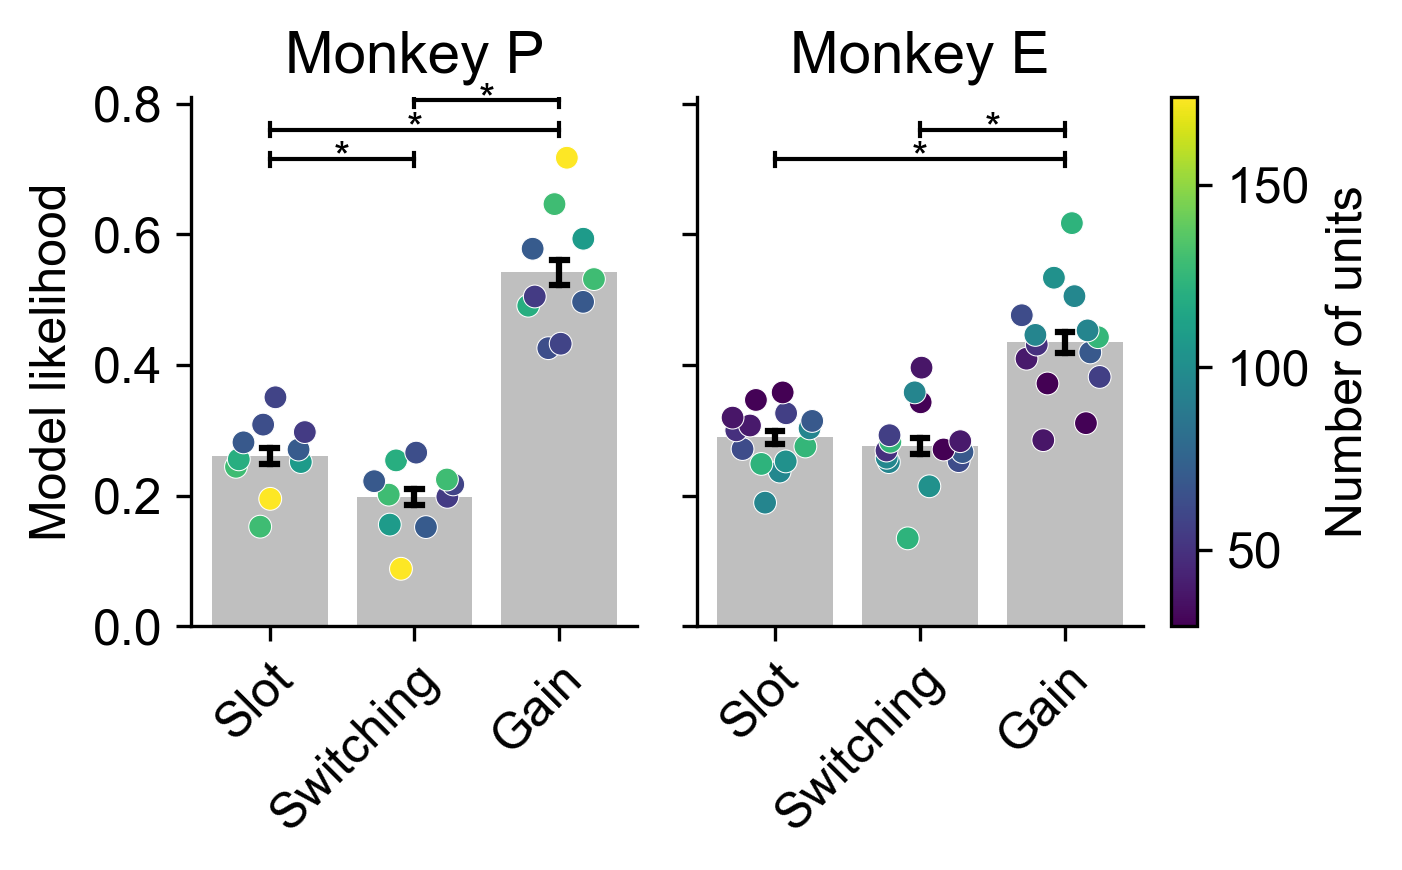

In [6]:
"""Plot."""

np.random.seed(2) # For reproducibility

def _add_x_jitter(row, y_safezone, parity, jitter=0.15, jitter_safezone=0.15):
    """Add x-jitter to row."""
    sample = np.random.uniform(0, jitter)
    prob = row["prob"]
    if prob > y_safezone[0] and prob < y_safezone[1]:
        sample += jitter_safezone
    if parity == 0:
        sample = -sample
    return sample

fig, axes = plt.subplots(1, 2, figsize=(4.8, 3), sharey=True, width_ratios=[1, 1.25])
min_neurons = data_df["num_neurons"].min()
max_neurons = data_df["num_neurons"].max()
for ax, subject in zip(axes, ["Perle", "Elgar"]):
    sns.despine(ax=ax)
    ax.set_title(f"Monkey {subject[0]}")
    subject_df = data_df[data_df.subject == subject]
    
    # Barplot of probabilities
    sns.barplot(
        data=subject_df,
        ax=ax,
        x="model",
        y="prob",
        zorder=0,
        color=(0.75, 0.75, 0.75),
        err_kws={'color': 'k', 'linewidth': 1.5},
        capsize=0.1,
    )
    
    # Add scatterplot of means
    mean_per_session_df = subject_df.groupby(["model", "session"])[["num_neurons", "prob"]].mean().reset_index()
    mean_per_session_df = mean_per_session_df.sort_values(by=["model", "prob"]).reset_index(drop=True)
    mean_per_session_df["model"] = mean_per_session_df["model"].map(
        {name: i for i, name in enumerate(MODEL_ORDER)})
    for i in range(3):
        y_mean = np.mean(mean_per_session_df[mean_per_session_df["model"] == i]["prob"])
        y_ci = scipy_stats.sem(mean_per_session_df[mean_per_session_df["model"] == i]["prob"]) * 1.96
        y_safezone = (y_mean - y_ci - 0.01, y_mean + y_ci + 0.01)
        for j, row in mean_per_session_df[mean_per_session_df["model"] == i].iterrows():
            parity = j % 2
            mean_per_session_df.loc[j, "model"] += _add_x_jitter(
                row,
                y_safezone,
                parity,
            )
    sns.scatterplot(
        data=mean_per_session_df,
        x="model",
        y="prob",
        hue="num_neurons",
        ax=ax,
        linewidth=0.25,
        legend=False,
        palette="viridis",
        hue_norm=(min_neurons, max_neurons),
        s=30,
    )
    
    # Plot significance brackets with stars
    count = 0
    for i, model1 in enumerate(MODEL_DIRS):
        for j, model2 in enumerate(MODEL_DIRS):
            if i >= j:
                continue
            model1_name = MODEL_TO_NAME[model1]
            model2_name = MODEL_TO_NAME[model2]
            model1_probs = subject_df[subject_df["model"] == model1_name]["prob"]
            model2_probs = subject_df[subject_df["model"] == model2_name]["prob"]
            model1_probs = model1_probs[np.isfinite(model1_probs)]
            model2_probs = model2_probs[np.isfinite(model2_probs)]
            t, p = scipy_stats.ttest_ind(model1_probs, model2_probs)
            if p < 0.01:
                count += 1
                y = 0.67 + 0.045 * count
                ax.plot([i, j], [y, y], 'k-', lw=1)
                bracket_hw = 0.01
                ax.plot([i, i], [y - bracket_hw, y + bracket_hw], 'k-', lw=1)
                ax.plot([j, j], [y - bracket_hw, y + bracket_hw], 'k-', lw=1)
                ax.text((i + j) / 2, y - 0.03, "*", ha='center', va='bottom', color='k')
    
    ax.set_ylabel('Model likelihood')
    ax.set_xlabel('')
    ax.set_ylim(0, 0.81)
    
    # Rotate x-tick labels
    ax.set_xticklabels(
        ax.get_xticklabels(),
        rotation=45,
        ha='right',
        rotation_mode='anchor',
    )

# Add colorbar for number of neurons
hues = mean_per_session_df["num_neurons"]
cmap = plt.cm.get_cmap('viridis')
norm = plt.Normalize(vmin=min_neurons, vmax=max_neurons)
hues = cmap(norm(hues))
sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
y_ticks = [50, 100, 150]
cbar = fig.colorbar(sm, ax=ax, label="Number of units", ticks=y_ticks)
cbar.set_label("Number of units")

# Save figure
fig.tight_layout()
fig.savefig(f"./plots/model_likelihoods.pdf", bbox_inches='tight', pad_inches=0.02)